# Store Item Demand Forecasting

Goal:

To develop a forecasting model for predicting daily sales of 50 items in 10 stores for the next month.

Data:

Data from the Kaggle [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview) was used, covering 5 years of sales.

Methodology:

For sales forecasting, data was loaded, the date column was converted and set as the index. Data visualization was performed to understand the dynamics. Time series decomposition and stationarity tests were carried out. The data was split into training and validation sets. A partial autocorrelation function was plotted, and seasonality was identified.

Next, various models were built and evaluated: NaiveSeasonal, XGBModel, ExponentialSmoothing, ARIMA, AutoARIMA, Prophet, and RNNModel. The Prophet model proved to be the best performing.

A backtest was performed for this model over a 1-year period with 1-month ahead forecasts each time. The model's residuals were analyzed.

Sales forecasts for the next month were generated for each item and store using Prophet. Forecast plots were created, and the results were saved to a CSV file.

Conclusion:

This project demonstrates how machine learning can be applied to forecast product demand in retail. The developed model can be used to improve business efficiency and make more informed decisions.

## Imports

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/data//train.csv')

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [ ]:
df

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


**Do sales patterns for each item vary significantly between stores?**


In [ ]:
# Calculate the mean sales per item for each date
item_mean_sales_by_date = df.groupby(['date', 'item'])['sales'].mean().reset_index() # roups all rows that have the same item together, take only the sales values for each group

# Now, you can create your Plotly Express line chart
fig = px.line(item_mean_sales_by_date, x='date', y='sales', color='item')

fig.update_layout(template="simple_white", font=dict(size=18),
                  title_text='item', width=950, title_x=0.5, height=500)

fig.show()

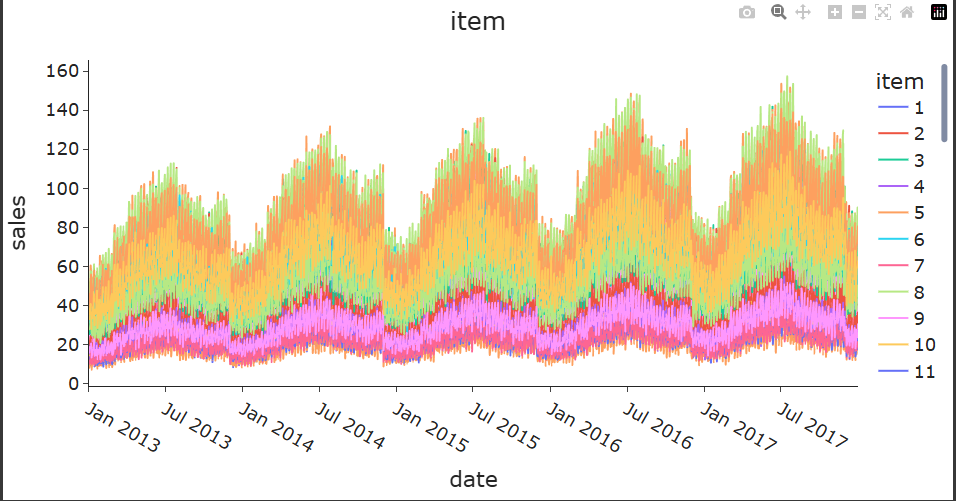

In [ ]:
fig = px.line(item_mean_sales_by_date, x='date', y='sales', color='item',
              facet_col="item", facet_col_wrap=5, title="Sales Trend per Item")

fig.update_layout(template="simple_white", font=dict(size=12),
                  width=1200, height=900)

fig.show()

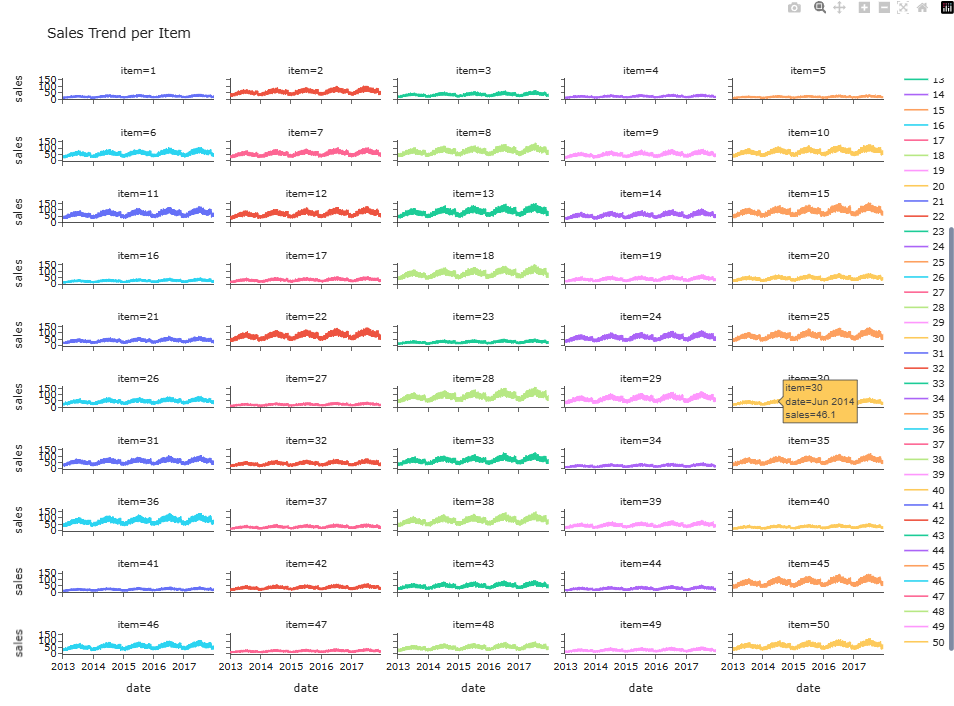

In [ ]:
import plotly.express as px

selected_item = 1

fig = px.box(df[df["item"] == selected_item], x="store", y="sales", title=f"Distribution of sales by store for item {selected_item}")
fig.show()

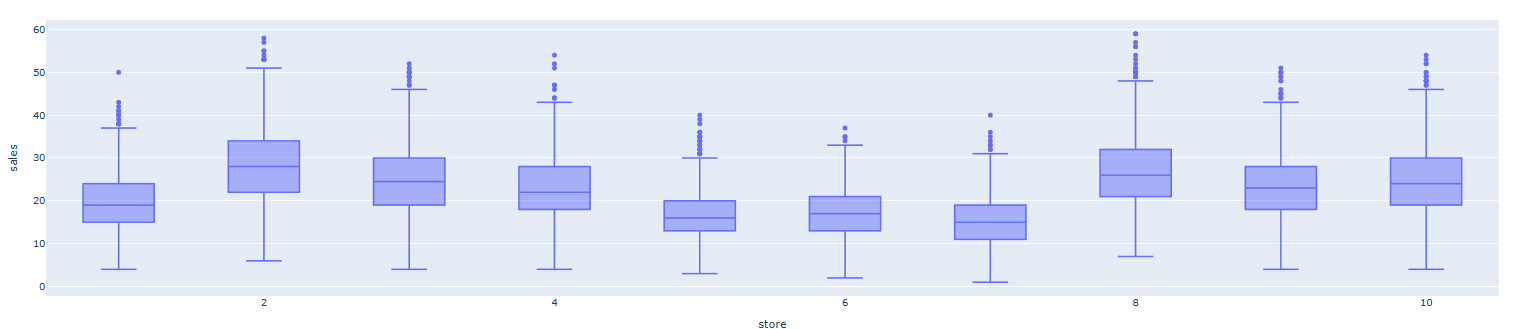

The graphs show seasonality with an annual cycle, characterized by peak sales in the summer. There is also an overall upward trend in sales over the years, indicating a positive trend

## Decomposition

Data subset representing sales of the item with `item == 1` in the store with `store == 1`.


resid  count    1462.000000
mean        0.000069
std         4.587162
min       -17.657465
25%        -3.048218
50%        -0.092739
75%         3.236542
max        17.908289
Name: resid, dtype: float64


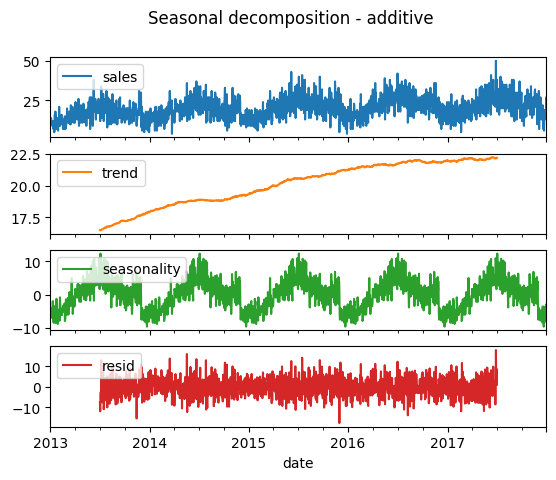

In [ ]:
import statsmodels.api as sm

# Select the subset for item 1 in store 1
subset = df[(df["item"] == 1) & (df["store"] == 1)].copy()

# Ensure data is sorted by date
subset = subset.sort_index()

# Perform seasonal decomposition using an additive model
decomposition = sm.tsa.seasonal_decompose(subset["sales"], model="additive", period=365)

# Extract components
subset["trend"] = decomposition.trend
subset["seasonality"] = decomposition.seasonal
subset["resid"] = decomposition.resid

print('resid ', subset["resid"].describe())
(
    subset
    .loc[:, ["sales", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive")
);

The residuals seem to contain no pattern and have a mean of zero, which is a good sign. Seasonality shows when the demand for the product is highest - during spring holidays, summer, and Christmas. The trend indicates an increase in sales over time.

## Stationarity test
ADF test (Augmented Dickey-Fuller Test)

The ADF test is used to test the hypothesis of the presence of a unit root in a time series, which indicates non-stationarity.

Null hypothesis (H0): The series has a unit root (non-stationary). Alternative hypothesis (H1): The series is stationary.

The test result provides a p-value. If the p-value is less than the chosen significance level (for example, 0.05), the null hypothesis is rejected, and the series is considered stationary.

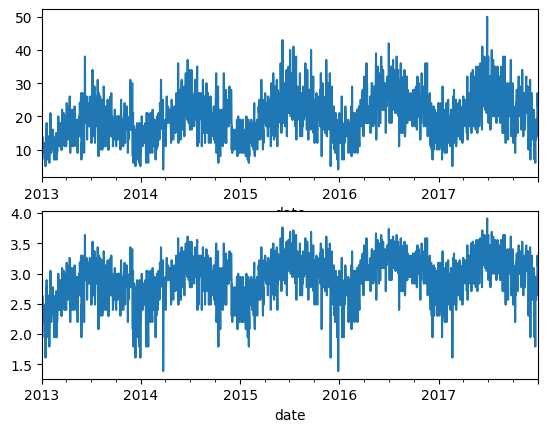

In [ ]:
plt.subplot(2, 1, 1)
subset.sales.plot()
plt.subplot(2, 1, 2)
np.log(subset.sales).plot();

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Performing the ADF test
result = adfuller(subset['sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.157671
p-value: 0.022569
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


The ADF Statistic value (-3.15) is less than the 5% critical value (-2.863), therefore we can reject the null hypothesis of non-stationarity. Also, the p-value of 0.02 is less than 0.05, which emphasizes that the series does not have a unit root (meaning it is stationary). This means that the time series is likely stationary at a 5% significance level, implying it has a constant mean, variance, and autocorrelation over time

## Darts

In [ ]:
!pip install darts --quiet

In [ ]:
from darts import TimeSeries

# Loading data into darts, the index was automatically converted to a Darts index
series = TimeSeries.from_dataframe(subset, value_cols='sales')

<Axes: xlabel='date'>

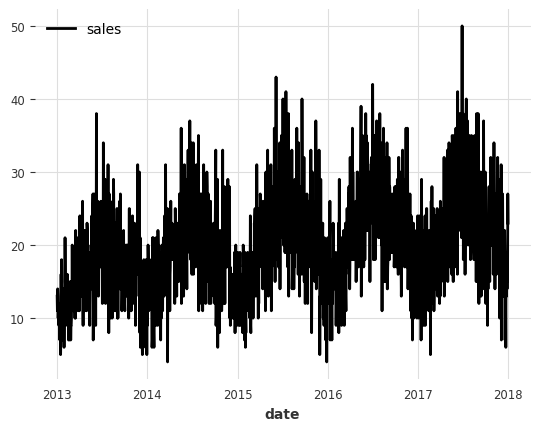

In [ ]:
series.plot()

### Splitting

<Axes: xlabel='date'>

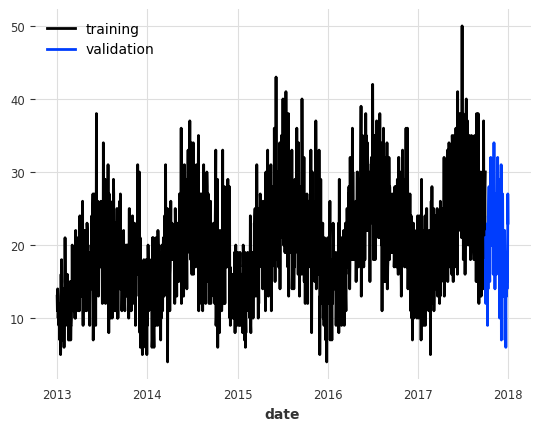

In [ ]:
train, val = series.split_before(pd.Timestamp("2017-10-01"))
train.plot(label="training")
val.plot(label="validation")

## Autocorrelation Function

<Figure size 1000x600 with 0 Axes>

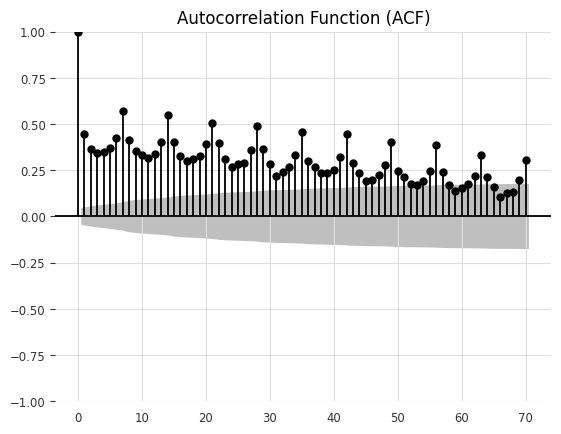

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Convert the darts TimeSeries object to a pandas Series
series_values = series.pd_series()

plt.figure(figsize=(10, 6))
plot_acf(series_values, lags=70)
plt.title('Autocorrelation Function (ACF)')
plt.show();

It can be seen from the graph that the autocorrelation values decrease with lag (time interval). This indicates positive autocorrelation at small lags. The fluctuations suggest the presence of seasonal patterns in the data. The first 50 lags and the periodic peak lags are above the shaded area - the confidence interval, which means they are statistically significant

## Seasonality

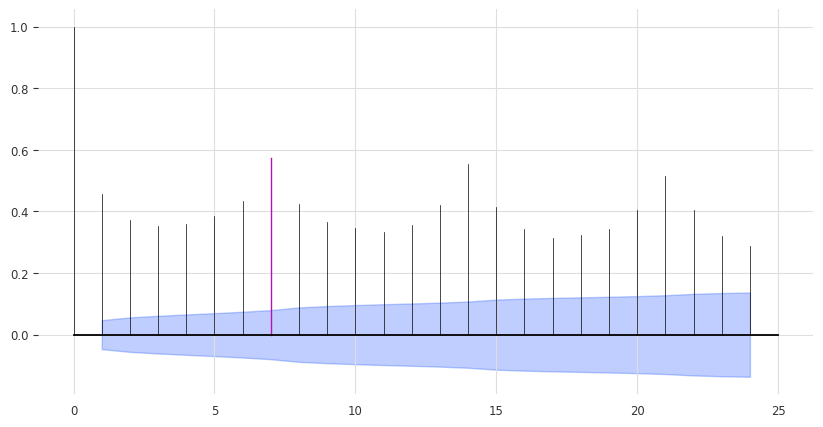

In [ ]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=7, alpha=0.05, max_lag=24)

ACF shows a peak at x = 7, which indicates a seasonal trend. The blue zone defines the significance of the statistic for the confidence level α=5%. We can also conduct a statistical test for seasonality for each candidate period m:

In [ ]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


In [ ]:
from darts.utils.statistics import check_seasonality

max_lag = 731  # Set max_lag explicitly
for m in range(2, max_lag):
is_seasonal, period = check_seasonality(train, m=m, max_lag=max_lag, alpha=0.05)
if is_seasonal:
print("There is seasonality of order {}.".format(period))

## NaiveSeasonal

NaiveSeasonal(K) always 'repeats' the value that occurred K steps ago.

In its most naive form, when K=1, this model simply always repeats the last value of the training series:

<Axes: xlabel='date'>

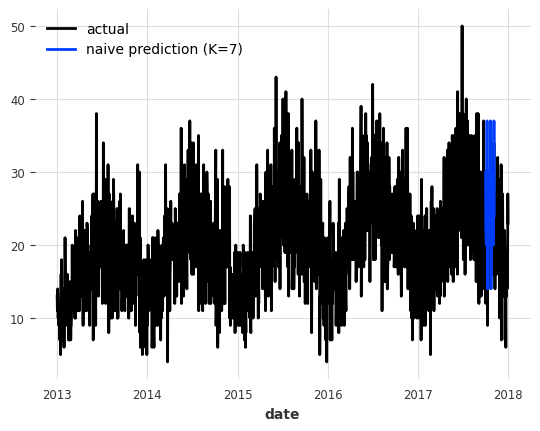

In [ ]:
from darts.models import NaiveSeasonal

seasonal_model = NaiveSeasonal(K=14)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive prediction (K=7)")

The naive model doesn't capture the trend and doesn't look very accurate.

<Axes: xlabel='date'>

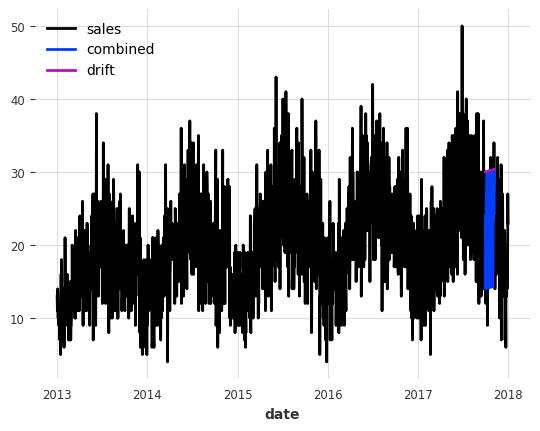

In [ ]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

The forecast of the drift combined model looks better than the naive one, but still doesn't show the trend.

In [ ]:
from darts.metrics import mape

print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(val, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 29.39%.


## XBGModel

In [ ]:
train.pd_dataframe()

component,sales
date,
2013-01-01,13.0
2013-01-02,11.0
2013-01-03,14.0
2013-01-04,13.0
2013-01-05,10.0
...,...
2017-09-26,18.0
2017-09-27,27.0
2017-09-28,23.0


In [ ]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

def enrich_with_date_features(df):
  # Feature Extraction - help models understand temporal patterns
  df["hour"] = df['date'].dt.hour
  df["dayofweek"] = df['date'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"]) # create cyclic representations of the year to capture seasonality
  df["cos_day"] = np.cos(df["dayofyear"])
  df["dayofmonth"] = df['date'].dt.day
  return df

# Adding date features
train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.pd_dataframe().reset_index())

# Data scaling
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(val)

# Building the XGBoost model
model = XGBModel(
    lags=7,  # Using the last 12 observations for prediction
    output_chunk_length=6,  # Forecasting 1 step ahead
    n_estimators=50,  # Number of trees in the model
    max_depth=2,  # Maximum depth of each tree
    learning_rate=0.1,  # Learning rate
    subsample=0.8,  # Fraction of data for random sampling of each tree
    colsample_bytree=0.8  # Fraction of features used for each tree
)

# Model training
model.fit(train_transformed)
pred = model.predict(6)
pred.values()

array([[0.4100851 ],
       [0.33715534],
       [0.37241435],
       [0.4198535 ],
       [0.4096488 ],
       [0.4883227 ]], dtype=float32)

In [ ]:
scaler.inverse_transform(pred) # is performing the inverse transformation of the scaled predictions (pred) to return them to their original scale.

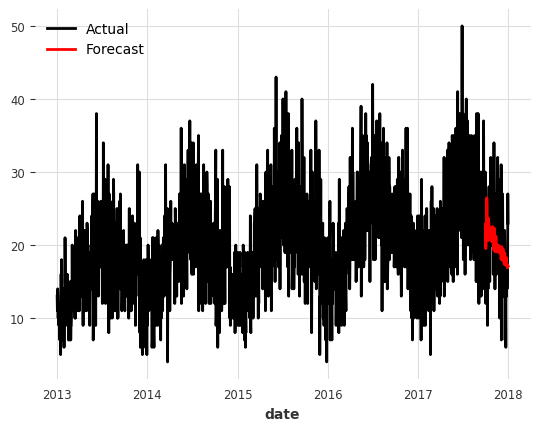

Mean absolute percentage error for the model: 25.87%.


In [ ]:
forecast = scaler.inverse_transform(model.predict(len(val)))
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()
print(
    f"Mean absolute percentage error for the model: {mape(val, forecast):.2f}%."
)

BEFORE Mean absolute percentage error for the model: 28.78%, after parameter tuning 25.87%.

Larger lag values increase the error. Forecasting 6 steps ahead makes the error smaller. Reducing the number of trees and the maximum depth of each also reduces the error. Date features did not yield any improvement.

The model predicts the seasonal decline in sales relatively well.

## ExponentialSmoothing

In [ ]:
from darts.models import ExponentialSmoothing, AutoARIMA, Theta

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

def fit_eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    eval_forecast(model, val, forecast)

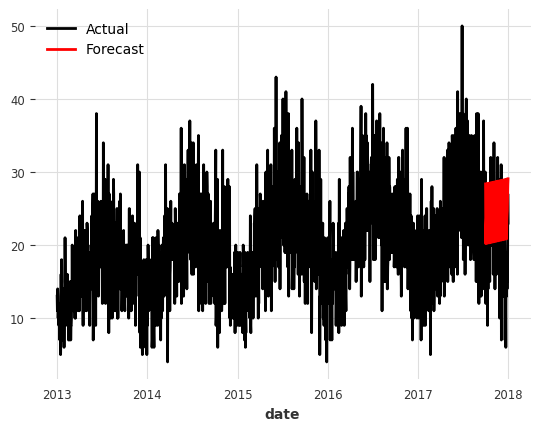

model ExponentialSmoothing() obtains MAPE: 39.01%


In [ ]:
def plot_results(series, forecast):

  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

model = ExponentialSmoothing()
fit_and_plot(model, series, train, val)

ExponentialSmoothing has a very high error at 39.01%. Therefore, its forecasting quality is very low.

## ARIMA

p – Number of autoregressive lags (AR)

d – Degree of differencing (I) Determines how many times the difference between values needs to be taken to make the series stationary.

q – Number of moving average lags (MA)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



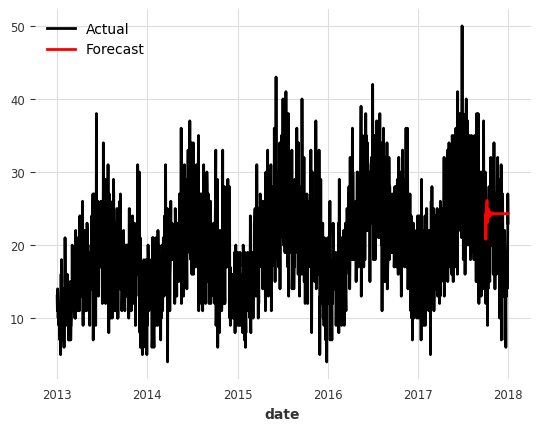

model ARIMA(p=7, q=1) obtains MAPE: 39.53%


In [ ]:
from darts.models import ARIMA

# Побудова та тренування моделі ARIMA
model = ARIMA(p=7, d=1, q=1) # integration models: ARIMA(p, d, q)
fit_and_plot(model, series, train, val)

ARIMA does not forecast seasonal data well.

## AutoARIMA

In [ ]:
# Building and training the AutoArima model
model = AutoARIMA(start_p=4, max_p=8, start_q=2) # try starting with different values and see what happens
model.fit(train)

display(model)

# Forecasting
forecast = model.predict(len(val))

# Visualization of results
plot_results(series, forecast)

In [ ]:
model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(6, 1, 5)   Log Likelihood               -5207.407
Date:                Tue, 18 Mar 2025   AIC                          10438.813
Time:                        21:22:22   BIC                          10504.304
Sample:                             0   HQIC                         10463.035
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5870      0.031    -18.900      0.000      -0.648      -0.526
ar.L2          0.0757      0.035      2.141      0.032       0.006       0.145
ar.L3         -0.6223      0.019    -33.186      0.000      -0.659      -0.586
ar.L4         -0.9678      0.020    -48.442      0.000      -1.007      -0.929
ar.L5         -0.1233      0.034     -3.584      0.000      -0.191      -0.056
ar.L6         -0.1415      0.028     -5.047      0.000      -0.196      -0.087
ma.L1         -0.3494      0.023    -15.382      0.000      -0.394      -0.305
ma.L2         -0.6971      0.021    -32.988      0.000      -0.739      -0.656
ma.L3          0.7371      0.018     39.915      0.000       0.701       0.773
ma.L4          0.4820      0.023     21.229      0.000       0.437       0.526
ma.L5         -0.8201      0.020    -40.627      0.000      -0.860      -0.781
sigma2        24.3958      0.780     31.259      0.000      22.866      25.925
===================================================================================
Ljung-Box (L1) (Q):                   1.84   Jarque-Bera (JB):                24.90
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
eval_forecast(model, val, forecast);

model AutoARIMA(start_p=6, max_p=14, start_q=5) obtains MAPE: 37.95%


37.95% is the best result obtained by AutoARIMA. Not very impressive.

## SARIMA

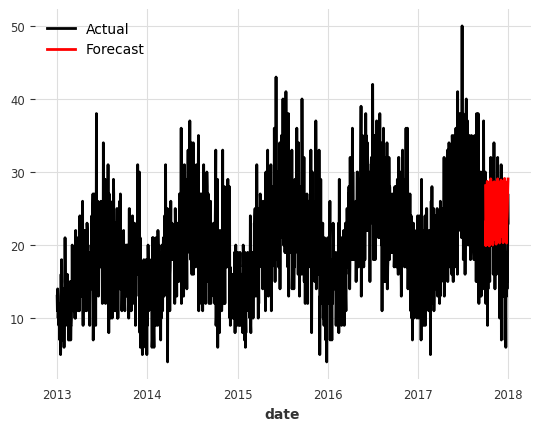

In [ ]:
# Creating an exogenous time series (for example, economic indicators)
exog = pd.DataFrame({
    'exog_var': np.random.randn(len(subset))
}, index=subset.index)
exog_series = TimeSeries.from_dataframe(exog)

# Splitting into training and test data
train, test = series.split_before(pd.Timestamp('2017-10-01'))
train_exog, test_exog = exog_series.split_before(pd.Timestamp('2017-10-01'))

# Building and training the SARIMAX model
model = ARIMA(1, 1, 1, seasonal_order=(1, 1, 1, 14))
model.fit(train, future_covariates=train_exog)

# Forecasting
forecast = model.predict(len(test), future_covariates=test_exog)

# Visualization of results
plot_results(series, forecast)

In [ ]:
eval_forecast(model, val, forecast);

model ARIMA(p=1, q=1, seasonal_order=(1, 1, 1, 14)) obtains MAPE: 38.82%


## Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt300118_/sti8asih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt300118_/d713rck3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30857', 'data', 'file=/tmp/tmpt300118_/sti8asih.json', 'init=/tmp/tmpt300118_/d713rck3.json', 'output', 'file=/tmp/tmpt300118_/prophet_modelyfugwir_/prophet_model-20250318212811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:28:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


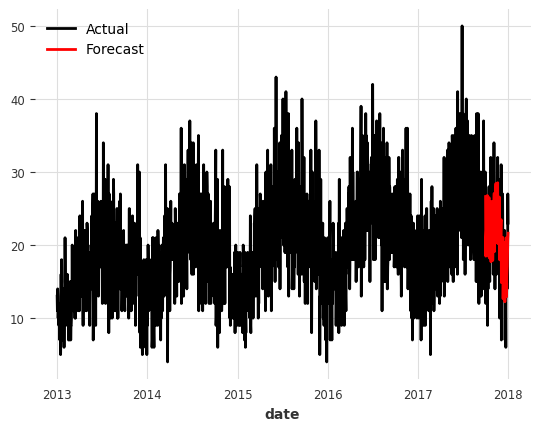

In [ ]:
from darts.models import Prophet

# Building and training the Prophet model
model = Prophet()
model.fit(train)

# Forecasting
forecast = model.predict(len(val))

# Visualization of results
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [ ]:
eval_forecast(model, val, forecast);

model Prophet() obtains MAPE: 23.80%


Prophet yields the best result at 23.80%. It predicted the downward trend relatively well.

## RNNModel

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

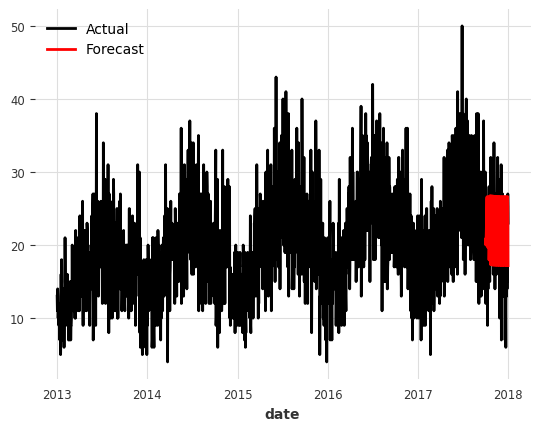

model RNNModel(model=LSTM, input_chunk_length=7, n_epochs=300) obtains MAPE: 36.87%


In [ ]:
from darts.models import RNNModel

# Building and training the LSTM model
model = RNNModel(model='LSTM', input_chunk_length=7, n_epochs=300)
model.fit(train)

# Forecasting
forecast = model.predict(len(test))

# Visualization of results
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

eval_forecast(model, val, forecast)

The RNNModel has an accuracy of 36.87%, which is a poor forecast

In [ ]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Data scaling
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# Create series with year and month attributes, using the length and frequency of your training data
year_series = datetime_attribute_timeseries(
    pd.date_range(start=train.start_time(), freq=train.freq_str, periods=len(train) + len(val)),  # Use training data's start time and frequency
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_before(val.start_time())  # Split covariates before the validation set

# Building and training the LSTM model
model = RNNModel(
    model="LSTM",
    input_chunk_length=30,  # Input length
    hidden_dim=30,  # Number of neurons in LSTM
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    training_length=32,
    force_reset=True,
)
model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

# Forecasting
forecast = scaler.inverse_transform(model.predict(len(test)))

# Visualization of results
series.plot(label='Actual')
forecast.

model RNNModel(model=LSTM, hidden_dim=30, training_length=32, input_chunk_length=30, batch_size=16, n_epochs=100, optimizer_kwargs={'lr': 0.001}, log_tensorboard=True, random_state=42, force_reset=True) obtains MAPE: 40.28%

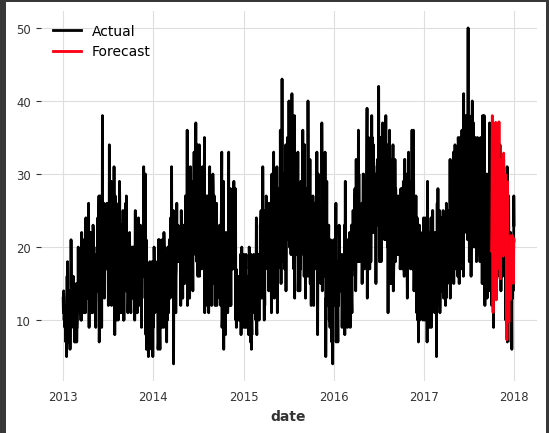

RNNModel with scaling gives a better result of 29.93%.

## Backtesting: Historical Forecast Simulation


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt300118_/m1isezca.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt300118_/7f_ndl9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84512', 'data', 'file=/tmp/tmpt300118_/m1isezca.json', 'init=/tmp/tmpt300118_/7f_ndl9g.json', 'output', 'file=/tmp/tmpt300118_/prophet_modelgz0w1qua/prophet_model-20250318221128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


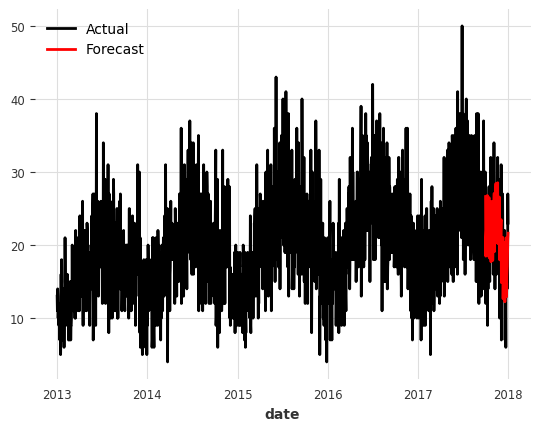

In [ ]:
# Building and training the Prophet model
model = Prophet()
model.fit(train)

# Forecasting
forecast = model.predict(len(val))

# Visualization of results
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [ ]:
eval_forecast(model, val, forecast);

model Prophet() obtains MAPE: 23.80%


In [ ]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-01-01"),  # can also be a float for the fraction of the series to start at
    'forecast_horizon': 30,  # 30 days forecasting
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True, **hfc_params)

series.plot(label="data")
historical_fcast.plot(label="backtest 1-month ahead forecast")
print(f"MAPE = {mape(series, historical_fcast):.2f}%")

MAPE = 20.37%

Prophet's accuracy slightly improved on the backtest.

This shows how the model would have performed on historical data if you had used it for forecasting in the past.

In [ ]:
historical_fcast_all = model.historical_forecasts(last_points_only=False, stride=30, **hfc_params)

series.plot(label="data")
for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}")

from darts import concatenate
historical_fcast_all = concatenate(historical_fcast_all, axis=0, ignore_time_axis=True)
print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")

MAPE = 21.11%

Forecasting errors for each backtesting step

In [ ]:
raw_errors = model.backtest(metric=mape, reduction=None, last_points_only=False, stride=30, **hfc_params)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [ ]:
average_error = model.backtest(
    metric=mape,
    reduction=np.mean,
    **hfc_params
)

print(f"Average error (MAPE) over all historical forecasts: {average_error:.2f}")

Average error (MAPE) over all historical forecasts: 20.43

On average, the model has an error of 20.43% compared to the actual values. This isn't very good; we need to experiment with features and other methods to improve accuracy.

Median MAPE and backtesting with precomputed forecasts

In [ ]:
hfc_precomputed = model.historical_forecasts(last_points_only=False, stride=30, **hfc_params)
new_error = model.backtest(historical_forecasts=hfc_precomputed, last_points_only=False, stride=30, **hfc_params)

print(f"Average error (MAPE) over all historical forecasts: {new_error:.2f}")

21.11%

Residual analysis

In [ ]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(model.residuals(series))

The distribution is normal and centered at 0, the model is not biased.

historical forecasts: 100%|██████████| 336/336 [00:11<00:00, 28.80it/s]


MAPE = 20.78%


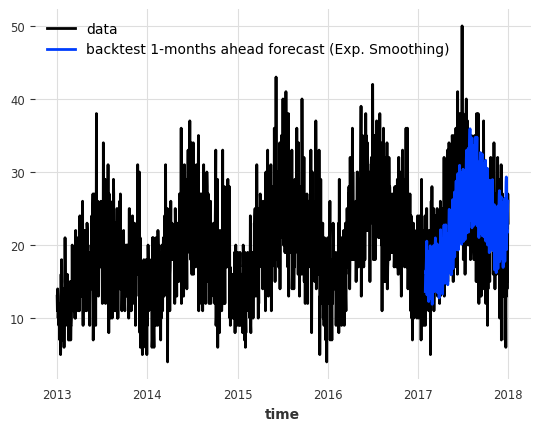

In [ ]:
model_theta = Theta(-3.5)
historical_fcast_theta = model_theta.historical_forecasts(**hfc_params)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 1-months ahead forecast (Exp. Smoothing)")
print(f"MAPE = {mape(historical_fcast_theta, series):.2f}%")

## Forecasting sales for the next month for each of the 50 items in each of the 10 stores

In [ ]:
import pandas as pd
from prophet import Prophet
from tqdm import tqdm
from darts import TimeSeries
import numpy as np

# Replace the previous code with Darts TimeSeries preparation
grouped = df.groupby(['store', 'item'])

results = []
future_period = 30
mapes = []  # List to store MAPE values for each group

for (store, item), group in tqdm(grouped):
    # Prepare data for Prophet
    group = group.reset_index()[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})

    # Check if the group has sufficient data
    if len(group) < 60:
        print(f"Skipping group with store: {store}, item: {item} due to insufficient data.")
        continue  # Skip this group if it has less than 60 data points

    # Create TimeSeries for Darts
    series = TimeSeries.from_dataframe(group, time_col='ds', value_cols='y')

    # Split into train and test (val)
    train, val = series.split_before(pd.Timestamp("2017-10-01"))

    # Create Prophet model
    model = Prophet(daily_seasonality=True)

    # Ensure the train DataFrame has the correct column names
    train_df = train.to_dataframe().rename(columns={train.to_dataframe().columns[0]: 'y'})
    train_df['ds'] = train_df.index

    model.fit(train_df)

    # Create future dates
    future = model.make_future_dataframe(periods=future_period)

    # Forecast
    forecast = model.predict(future)

    # Convert the result to TimeSeries
    forecast_series = TimeSeries.from_dataframe(forecast[['ds', 'yhat']], time_col='ds', value_cols='yhat')

    # Extract the forecast for the next month
    forecast_next_month = forecast_series[-future_period:]

    # Convert to DataFrame to add store and item columns
    forecast_next_month_df = forecast_next_month.to_dataframe()

    # Add store and item before renaming
    forecast_next_month_df['store'] = store
    forecast_next_month_df['item'] = item

    # Now rename columns, including 'ds' to 'date'
    forecast_next_month_df = forecast_next_month_df.rename(columns={'ds': 'date', 'yhat': 'predicted_sales'})

    # Calculate MAPE if we have validation data
    if len(val) > 0:
        actual = val.values()
        # Ensure that predicted values are within the range of actual values
        predicted = forecast_next_month_df['predicted_sales'].values[:len(actual)]

        mape_val = np.mean(np.abs((actual - predicted) / actual)) * 100
        mapes.append(mape_val)

    results.append(forecast_next_month_df)

# Concatenate all results, handling empty results list
if results:
    final_forecast = pd.concat(results)
    # Use filter to select the required columns in the desired order
    final_forecast = final_forecast.filter(items=['date', 'store', 'item', 'predicted_sales'])
    print(final_forecast.head())
else:
    print("No groups had sufficient data for forecasting.")
    final_forecast = pd.DataFrame()  # Create an empty DataFrame if results is empty

# Print the MAPE values for each store and item
print(f"MAPE for each store and item: {mapes}")

# Optionally, calculate the average MAPE across all forecasts
average_mape = np.mean(mapes) if mapes else None
print(f"Average MAPE: {average_mape:.2f}" if average_mape is not None else "No MAPE calculated.")

print(final_forecast.head())


Mape - 26%

In [ ]:
# Reset the index to convert 'ds' into a regular column
final_forecast.reset_index(inplace=True)

# Rename 'ds' to 'date'
final_forecast = final_forecast.rename(columns={'ds': 'date'})

# Check the result to confirm that 'date' is now a column
print(final_forecast.head())

        date  store  item  predicted_sales
0 2017-10-01      1     1        26.644207
1 2017-10-02      1     1        18.488402
2 2017-10-03      1     1        21.140996
3 2017-10-04      1     1        21.856543
4 2017-10-05      1     1        22.443573


In [ ]:
final_forecast.to_csv('forecast_next_month.csv', index=False)

In [ ]:
final_forecast

,date,store,item,predicted_sales
0,2017-10-01,1,1,26.644207
1,2017-10-02,1,1,18.488402
2,2017-10-03,1,1,21.140996
3,2017-10-04,1,1,21.856543
4,2017-10-05,1,1,22.443573
...,...,...,...,...
14995,2017-10-26,10,50,82.619794
14996,2017-10-27,10,50,87.694516
14997,2017-10-28,10,50,92.549629
14998,2017-10-29,10,50,97.828661


Forecast graph

In [ ]:
import plotly.express as px

# Assuming 'final_forecast' contains your forecast data
fig = px.line(final_forecast, x='date', y='predicted_sales',
              color='item', facet_col='store',
              facet_col_wrap=2,  # Adjust wrap for better layout
              title="Sales Forecasts by Store and Item")

fig.show()

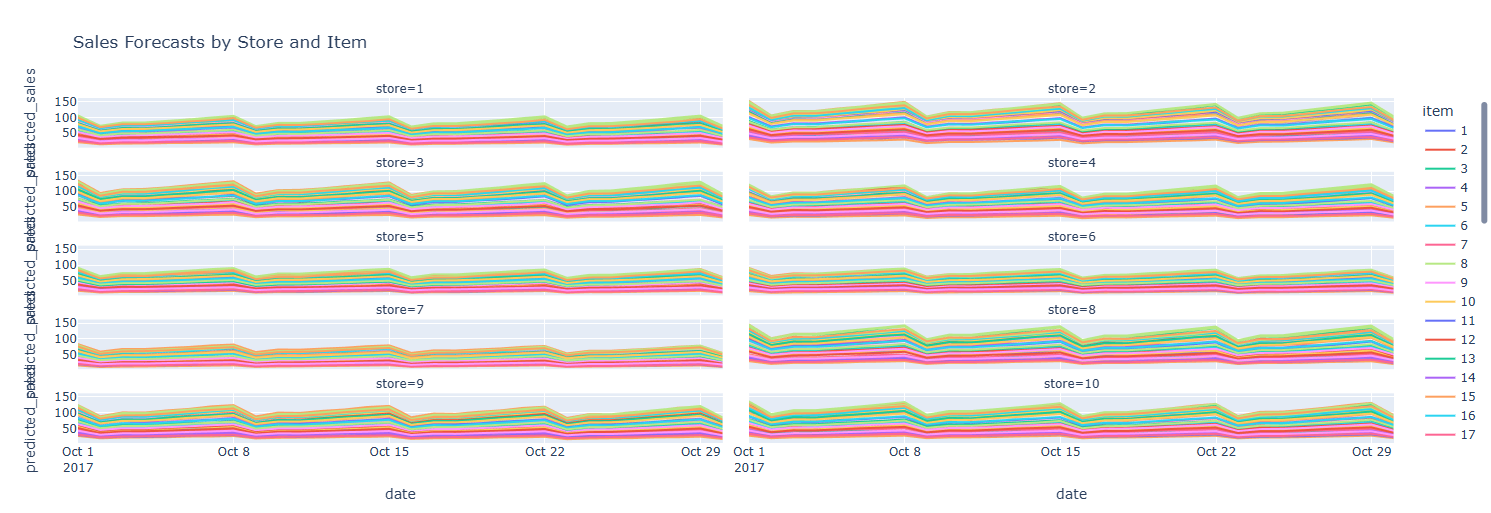

Actual graph

In [ ]:
import plotly.express as px
import pandas as pd

# Assuming 'df' contains the original sales data
# Convert 'date' to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Filter df to include only the dates in final_forecast for comparison
df_filtered = df[df['date'].isin(final_forecast['date'])]

# Create the Plotly Express line chart using the filtered df
fig = px.line(df_filtered,
              x='date',
              y='sales',  # Plot actual sales
              color='item',
              facet_col='store',
              facet_col_wrap=2,  # Adjust wrap for better layout
              title="Actual Sales by Store and Item (For Forecast Period)")

fig.show()

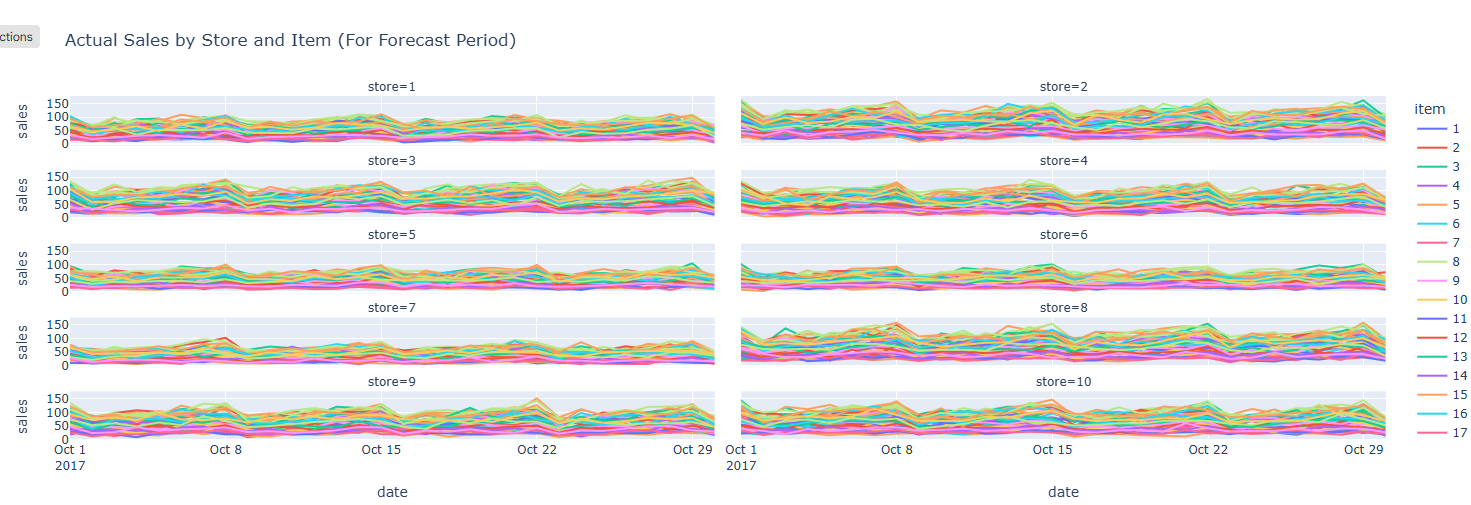

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Assuming 'final_forecast' contains your forecast data
# Create an interactive table
table = widgets.Output()
with table:
    display(final_forecast)

# Create widgets for filtering
store_dropdown = widgets.Dropdown(options=final_forecast['store'].unique(),
                                  description='Store:')
item_dropdown = widgets.Dropdown(options=final_forecast['item'].unique(),
                                 description='Item:')

# Define a function to update the table based on filter selections
def update_table(change):
    filtered_data = final_forecast[
        (final_forecast['store'] == store_dropdown.value) &
        (final_forecast['item'] == item_dropdown.value)
    ]
    with table:
        table.clear_output()
        display(filtered_data)

# Observe filter changes
store_dropdown.observe(update_table, names='value')
item_dropdown.observe(update_table, names='value')

# Display the widgets and table
display(widgets.HBox([store_dropdown, item_dropdown]))
display(table)

Output()

Forecasting for the Next Several Months

In [ ]:
import pandas as pd
from prophet import Prophet
from tqdm import tqdm
from darts import TimeSeries
import numpy as np

# Replace the previous code with Darts TimeSeries preparation
grouped = df.groupby(['store', 'item'])

results = []
future_period = 90
mapes = []  # List to store MAPE values for each group

for (store, item), group in tqdm(grouped):
    # Prepare data for Prophet
    group = group.reset_index()[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})

    # Check if the group has sufficient data
    if len(group) < 60:
        print(f"Skipping group with store: {store}, item: {item} due to insufficient data.")
        continue  # Skip this group if it has less than 60 data points

    # Create TimeSeries for Darts
    series = TimeSeries.from_dataframe(group, time_col='ds', value_cols='y')

    # Split into train and test (val)
    train, val = series.split_before(pd.Timestamp("2017-12-01"))

    # Create Prophet model
    model = Prophet(daily_seasonality=True)

    # Ensure the train DataFrame has the correct column names
    train_df = train.to_dataframe().rename(columns={train.to_dataframe().columns[0]: 'y'})
    train_df['ds'] = train_df.index

    model.fit(train_df)

    # Create future dates
    future = model.make_future_dataframe(periods=future_period)

    # Forecast
    forecast = model.predict(future)

    # Convert the result to TimeSeries
    forecast_series = TimeSeries.from_dataframe(forecast[['ds', 'yhat']], time_col='ds', value_cols='yhat')

    # Extract the forecast for the next month
    forecast_next_month = forecast_series[-future_period:]

    # Convert to DataFrame to add store and item columns
    forecast_next_month_df = forecast_next_month.to_dataframe()

    # Add store and item before renaming
    forecast_next_month_df['store'] = store
    forecast_next_month_df['item'] = item

    # Now rename columns, including 'ds' to 'date'
    forecast_next_month_df = forecast_next_month_df.rename(columns={'ds': 'date', 'yhat': 'predicted_sales'})

    # Calculate MAPE if we have validation data
    if len(val) > 0:
        actual = val.values()
        # Ensure that predicted values are within the range of actual values
        predicted = forecast_next_month_df['predicted_sales'].values[:len(actual)]

        mape_val = np.mean(np.abs((actual - predicted) / actual)) * 100
        mapes.append(mape_val)

    results.append(forecast_next_month_df)

# Concatenate all results, handling empty results list
if results:
    final_forecast = pd.concat(results)
    # Use filter to select the required columns in the desired order
    final_forecast = final_forecast.filter(items=['date', 'store', 'item', 'predicted_sales'])
    print(final_forecast.head())
else:
    print("No groups had sufficient data for forecasting.")
    final_forecast = pd.DataFrame()  # Create an empty DataFrame if results is empty

# Print the MAPE values for each store and item
print(f"MAPE for each store and item: {mapes}")

# Optionally, calculate the average MAPE across all forecasts
average_mape = np.mean(mapes) if mapes else None
print(f"Average MAPE: {average_mape:.2f}" if average_mape is not None else "No MAPE calculated.")

print(final_forecast.head())

Average MAPE: 24.77

In [ ]:
# Reset the index to convert 'ds' into a regular column
final_forecast.reset_index(inplace=True)

# Rename 'ds' to 'date'
final_forecast = final_forecast.rename(columns={'ds': 'date'})

# Check the result to confirm that 'date' is now a column
print(final_forecast.head())
final_forecast.to_csv('forecast_few_months.csv', index=False)

        date  store  item  predicted_sales
0 2017-12-01      1     1        21.448600
1 2017-12-02      1     1        22.878734
2 2017-12-03      1     1        23.228607
3 2017-12-04      1     1        14.581940
4 2017-12-05      1     1        16.839332


In [ ]:
final_forecast

,date,store,item,predicted_sales
0,2017-12-01,1,1,21.448600
1,2017-12-02,1,1,22.878734
2,2017-12-03,1,1,23.228607
3,2017-12-04,1,1,14.581940
4,2017-12-05,1,1,16.839332
...,...,...,...,...
44995,2018-02-24,10,50,83.296076
44996,2018-02-25,10,50,88.732459
44997,2018-02-26,10,50,60.133728
44998,2018-02-27,10,50,69.702740


In [ ]:
import plotly.express as px

# Assuming 'final_forecast' contains your forecast data
fig = px.line(final_forecast, x='date', y='predicted_sales',
              color='item', facet_col='store',
              facet_col_wrap=2,  # Adjust wrap for better layout
              title="Sales Forecasts by Store and Item")

fig.show()

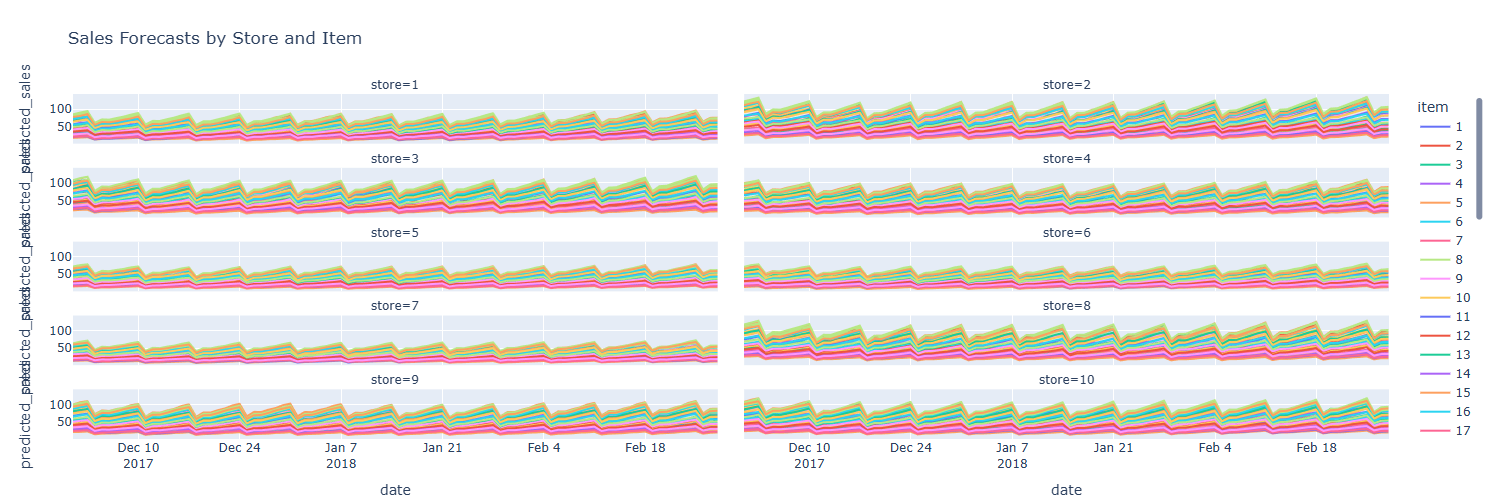

In [ ]:
import plotly.express as px
import pandas as pd

# Assuming 'df' contains the original sales data
# Convert 'date' to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Filter df to include only the dates in final_forecast for comparison
df_filtered = df[df['date'].isin(final_forecast['date'])]

# Create the Plotly Express line chart using the filtered df
fig = px.line(df_filtered,
              x='date',
              y='sales',  # Plot actual sales
              color='item',
              facet_col='store',
              facet_col_wrap=2,  # Adjust wrap for better layout
              title="Actual Sales by Store and Item (For Forecast Period)")

fig.show()

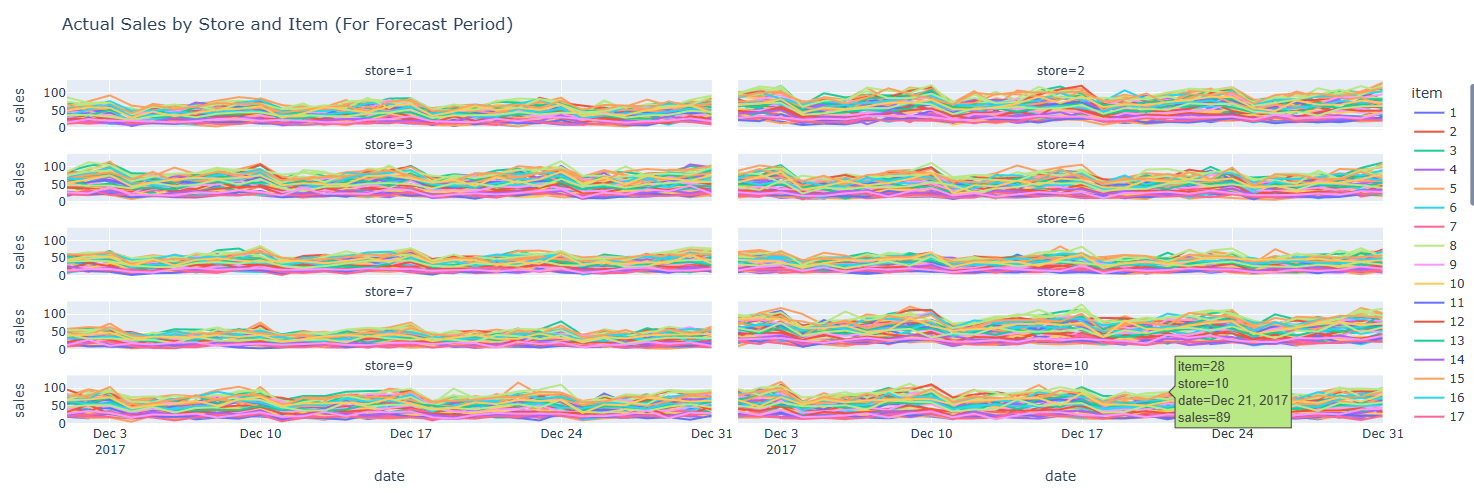

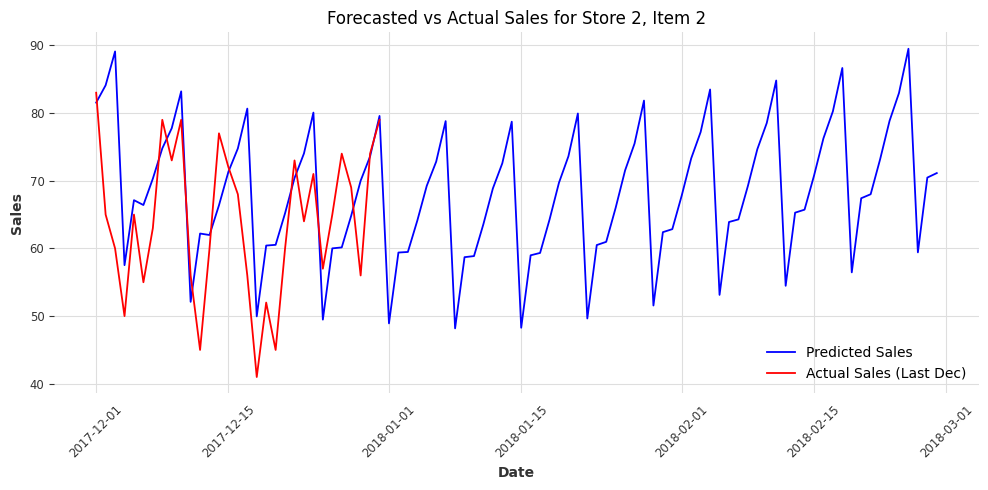

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming final_forecast and df are already defined and preprocessed

# Choose one store and item from final_forecast
example = final_forecast[(final_forecast['store'] == 2) & (final_forecast['item'] == 2)]

# Filter for store 2, item 2, and last month of December in df
df['date'] = pd.to_datetime(df['date'].astype(str))
december_data = df[(df['store'] == 2) & (df['item'] == 2) & (df['date'].dt.month == 12)]
last_december_month = december_data['date'].dt.to_period('M').max()
last_month_data = december_data[december_data['date'].dt.to_period('M') == last_december_month]

# Plot both on the same figure
plt.figure(figsize=(10, 5))

# Plot predicted sales
plt.plot(example['date'], example['predicted_sales'], label='Predicted Sales', color='blue')

# Plot actual sales for last month of December
plt.plot(last_month_data['date'], last_month_data['sales'], label='Actual Sales (Last Dec)', color='red')

plt.title("Forecasted vs Actual Sales for Store 2, Item 2")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()